# Problem Set 3 Notebook 

### Contributors : 
* Nourchene Ben Romdhane
* Firas Kanoun
* Zeineb Sahnoun
* Sami Ben Hassen

## Remarques:
### Zeineb: Je propose de changer toute la partie encoded_data par ce que j'ai mis plus bas dans "Data preprocssing - Aggregation", khater ca n'a pas de sens de garder certains features comme StreamingTV, TechSupport, DeviceProtection... avec trois valeurs possibles dont une qui se repete tout le temps 2 -> "No Internet Service" alors que c'est aussi un feature à part entiere...

# Relevant Imports

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import LabelEncoder
%matplotlib inline

from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.base import TransformerMixin
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split, validation_curve, ShuffleSplit, KFold, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn import linear_model, datasets, svm
from sklearn.metrics import auc, confusion_matrix, make_scorer, roc_auc_score, roc_curve, recall_score, f1_score, precision_score, accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier 
from itertools import cycle
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from xgboost import XGBClassifier

# Data Description:

In [2]:
path = 'Telco-Customer-Churn.csv'
data = pd.read_csv(path)
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# Dealing with NAs :

In [3]:
data['TotalCharges'] = data['TotalCharges'].replace(" ", np.nan).astype('float32') # Force empty values to be "Nan"
data["SeniorCitizen"]=data["SeniorCitizen"].astype("object") #Change data type of variable of interest
data = data[data["TotalCharges"].notnull()]  #let's drop the "Nan values, since they will drive down our sample mean
data = data.reset_index()[data.columns] #and let's reindex... just in case we want to loop the dataframe.

////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

## Categorical Data:

In [4]:
data.select_dtypes(include='object').describe().transpose().sort_values('unique')

,count,unique,top,freq
Churn,7032,2,No,5163
gender,7032,2,Male,3549
SeniorCitizen,7032,2,0,5890
Partner,7032,2,No,3639
Dependents,7032,2,No,4933
PhoneService,7032,2,Yes,6352
PaperlessBilling,7032,2,Yes,4168
Contract,7032,3,Month-to-month,3875
StreamingMovies,7032,3,No,2781
StreamingTV,7032,3,No,2809


**Above you can see the different values and distribution of all categorical features. Let's study them in depth and then encode them for the prediction. We can drop the customerID since it's of type object and we already have an indexing of the data.**

In [5]:
encoded_data = data.copy()
encoded_data.drop(columns = ['customerID'], inplace = True)
encoded_data.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.850000,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.500000,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.150002,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.750000,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.649994,Yes


**Let's now encode the categorical features.**

In [6]:
label_enc_gender= LabelEncoder()
gender_encoded = label_enc_gender.fit_transform(encoded_data.gender)
encoded_data['gender']=gender_encoded

In [7]:
label_enc_partner= LabelEncoder()
partner_encoded = label_enc_partner.fit_transform(encoded_data.Partner)
encoded_data['Partner']=partner_encoded

In [8]:
label_enc_dependents= LabelEncoder()
dependents_encoded = label_enc_dependents.fit_transform(encoded_data.Dependents)
encoded_data['Dependents']=dependents_encoded

In [9]:
label_enc_ph= LabelEncoder()
ph_encoded = label_enc_ph.fit_transform(encoded_data.PhoneService)
encoded_data['PhoneService']=ph_encoded

In [10]:
label_enc_ML= LabelEncoder()
ML_encoded = label_enc_ML.fit_transform(encoded_data.MultipleLines)
encoded_data['MultipleLines']=ML_encoded

In [11]:
IS_mapper = {'DSL':1,'Fiber optic':2,'No':0}
encoded_data['InternetService'] = encoded_data['InternetService'].replace(IS_mapper)

In [12]:
OS_mapper = {'No internet service':1,'Yes':2,'No':0}
encoded_data['OnlineSecurity'] = encoded_data['OnlineSecurity'].replace(OS_mapper)

In [13]:
encoded_data['OnlineBackup'] = encoded_data['OnlineBackup'].replace(OS_mapper)

In [14]:
encoded_data['TechSupport'] = encoded_data['TechSupport'].replace(OS_mapper)

In [15]:
encoded_data['StreamingTV'] = encoded_data['StreamingTV'].replace(OS_mapper)

In [16]:
encoded_data['StreamingMovies'] = encoded_data['StreamingMovies'].replace(OS_mapper)

In [17]:
label_enc_contract= LabelEncoder()
contract_encoded = label_enc_contract.fit_transform(encoded_data.Contract)
encoded_data['Contract']=contract_encoded

In [18]:
label_enc_paper= LabelEncoder()
paper_encoded = label_enc_paper.fit_transform(encoded_data.PaperlessBilling)
encoded_data['PaperlessBilling']=paper_encoded

In [19]:
encoded_data['DeviceProtection'] = encoded_data['DeviceProtection'].replace(OS_mapper)

In [20]:
label_enc_payment= LabelEncoder()
payment_encoded = label_enc_payment.fit_transform(encoded_data.PaymentMethod)
encoded_data['PaymentMethod']=payment_encoded

In [21]:
encoded_data["SeniorCitizen"]=encoded_data["SeniorCitizen"].astype("int32")
encoded_data.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,1,1,0,2,0,0,0,0,0,1,2,29.85,29.850000,No
1,1,0,0,0,34,1,0,1,2,0,2,0,0,0,1,0,3,56.95,1889.500000,No
2,1,0,0,0,2,1,0,1,2,2,0,0,0,0,0,1,3,53.85,108.150002,Yes
3,1,0,0,0,45,0,1,1,2,0,2,2,0,0,1,0,0,42.30,1840.750000,No
4,0,0,0,0,2,1,0,2,0,0,0,0,0,0,0,1,2,70.70,151.649994,Yes


/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

## Correlation Study

 In this section, we are interested to know which features play a role in knowing if a costumer is loyal or not. We will look at two of the features from our data set and use chi-square tests to see if these features are important to predict customer's loyalty .
 
 We have 2 possible hypotheses for the ChiSquare test :
 
   **H0 (Null Hypothesis): There is no relationship between the first and the second variable.**
   
   **H1 (Alternative Hypothesis): There is a relationship between the first and the second variable.**

### Correlation between Online Security and Churn

In [22]:
# Contingency table
crosstab = pd.crosstab(data['OnlineSecurity'], data['Churn'])
stats.chi2_contingency(crosstab)

(846.6773889208487,
 1.4006867477839222e-184,
 2,
 array([[2567.54991468,  929.45008532],
        [1116.00682594,  403.99317406],
        [1479.44325939,  535.55674061]]))

**The first value (849.99) is the Test Statistic value, followed by the p-value (2.66e-185), then comes the degrees of freedom (2), and lastly it outputs the expected frequencies as an array. We can reject the null hypothesis at significance level 95% since the p-value is less than 0.05. Thus, the results indicate that there is a relationship between Online Security and loyalty to the company.**

### Correlation between the gender of the user and Churn

In [23]:
# contingency table
crosstab = pd.crosstab(data['gender'], data['Churn'])
stats.chi2_contingency(crosstab)

(0.47545453727386294,
 0.4904884707065509,
 1,
 array([[2557.27090444,  925.72909556],
        [2605.72909556,  943.27090444]]))

**We can see that the Test statistic is equal to 0.484, the p value is equal to 0.486 and the degree of freedom is 1. Since the p-value is a lot greater than 0.05, this means that we cannot reject the null hypothesis, and that the gender may not play a role in regards to being loyal to the company which seems very logical.**

NB : The other features can be studied in the same way, here we provided examples of 2 different outcomes of the chi-square test.

# Data preprocssing - Aggregation

**Here we aggregate features a a preprocessing step to predict churn. We used the code provided in the solution to the first homework.**

In [25]:
# If there are only 2 values (and they are Yes/No, 
# we are going to convert them to Numerical, where "Yes"=1, "No"=0)

data["Male"]=data['gender'].map(lambda s :1  if s =='Male' else 0)
data=data.drop(columns="gender")
data["InternetYes"]=data['InternetService'].map(lambda s :0  if s =='No' else 1)


yes_no_cols=["Partner","Dependents","PhoneService","MultipleLines","PaperlessBilling","OnlineSecurity","OnlineBackup","DeviceProtection","TechSupport","StreamingTV","StreamingMovies"]
for col in yes_no_cols:
    data[col]=data[col].map(lambda s :1  if s =='Yes' else 0)

# For Internet Service, now information is expanded in two columns, 
# so we don't need a "DSL" and a "Fiber optic" column
# of dummies. We will use a column called "Fiber Optic" 
# where the negative option implies "DSL" if "Internet Service" is 1
data["FiberOptic"]=data["InternetService"].map(lambda s :1  if s =='Fiber optic' else 0)
data=data.drop(columns="InternetService")

dummies=pd.get_dummies(data["Contract"],prefix="Contract")
data = pd.concat([data, dummies], axis=1)
data=data.drop(columns="Contract")

dummies=pd.get_dummies(data["PaymentMethod"],prefix="Pay")
data = pd.concat([data, dummies], axis=1)
data=data.drop(columns="PaymentMethod")

data["SeniorCitizen"]=data["SeniorCitizen"].astype("int32")

data.head()

,customerID,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,Male,InternetYes,FiberOptic,Contract_Month-to-month,Contract_One year,Contract_Two year,Pay_Bank transfer (automatic),Pay_Credit card (automatic),Pay_Electronic check,Pay_Mailed check
0,7590-VHVEG,0,1,0,1,0,0,0,1,0,...,0,1,0,1,0,0,0,0,1,0
1,5575-GNVDE,0,0,0,34,1,0,1,0,1,...,1,1,0,0,1,0,0,0,0,1
2,3668-QPYBK,0,0,0,2,1,0,1,1,0,...,1,1,0,1,0,0,0,0,0,1
3,7795-CFOCW,0,0,0,45,0,0,1,0,1,...,1,1,0,0,1,0,1,0,0,0
4,9237-HQITU,0,0,0,2,1,0,0,0,0,...,0,1,1,1,0,0,0,0,1,0


# Predicting Churn

In this part, we will study several models to predict customer behavior (churn), and finally give the best of them. This prediction problem is hence a binary classification, where the target feature (churn) is equal to 0 if a costumer leaves the company, and 1 if he is loyal.

In [26]:
#target encoding 
label_enc_target= LabelEncoder()
churn_encoded = label_enc_target.fit_transform(encoded_data.Churn)
encoded_data['Churn']=churn_encoded

In [27]:
target = encoded_data.Churn
features = encoded_data.drop(columns = ['Churn'])
features.head(3)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,0,0,1,0,1,0,1,1,0,2,0,0,0,0,0,1,2,29.85,29.850000
1,1,0,0,0,34,1,0,1,2,0,2,0,0,0,1,0,3,56.95,1889.500000
2,1,0,0,0,2,1,0,1,2,2,0,0,0,0,0,1,3,53.85,108.150002


Many classifiers work on standardized features (logistic). Moreover, normalization might improve convergence speed due to more smooth optimization surface. We will standerdize the features and we can then compare the performance of some models according to the input (standardized data or not) they are given. 

In [28]:
def standerdize(df, col):
    df_stand = df.copy()
    for col in list(col):
        df_stand[col] = ((df_stand[col]-df_stand[col].mean())/df_stand[col].std())
        
    return df_stand
        

features_list = list(features.columns)
stand_feat = standerdize(features, features_list)
stand_feat.head(3)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,-1.009358,-0.440296,1.035543,-0.652259,-1.280157,-3.056117,0.062662,-0.287832,-0.917772,1.242786,-1.026915,-0.924201,-1.112553,-1.121422,-0.826676,0.828880,0.399777,-1.161611,-0.994123
1,0.990588,-0.440296,-0.965539,-0.652259,0.064298,0.327166,-0.991493,-0.287832,1.407912,-1.028925,1.245352,-0.924201,-1.112553,-1.121422,0.373899,-1.206275,1.336541,-0.260859,-0.173727
2,0.990588,-0.440296,-0.965539,-0.652259,-1.239416,0.327166,-0.991493,-0.287832,1.407912,1.242786,-1.026915,-0.924201,-1.112553,-1.121422,-0.826676,0.828880,1.336541,-0.363897,-0.959580


**We finally obtained our encoded data and target, we now need to divide it into training and test sets.**

In [29]:
seed = 2
#Split standardized features
X_train, X_test, y_train, y_test = train_test_split(stand_feat, target, test_size = 0.2, random_state = seed)

#Split normal features
''' Remove comment from this line to use non-normalized features'''
#X_train_norm, X_test_norm, y_train_norm, y_test_norm = train_test_split(features, target, test_size = 0.2, random_state = seed)

' Remove comment from this line to use non-normalized features'

We need to separate a part of the training set known as validation set. We can then tune parameters by measuring their performance on the validation set. Finally we obtain the test score by training our model on the training set and measuring its performance on the test set.
We divide data into training (60%), validation (20%) and test sets (20%).

In [30]:
seed = 1

# Separate target and features into test, training, and validation sets

X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size = 0.25, random_state = seed)

## 1. Logistic Regression Model :

### Hyper-parameter tuning

In [31]:
estimators = []
estimators.append(('lr_clf', LogisticRegression()))
pipeline = Pipeline(estimators)
pipeline.set_params(lr_clf__penalty='l1')

# Finding best value of C parameter using validation set
scores = []
Cs = []
for C in np.logspace(-4, 5, 10):
    pipeline.set_params(lr_clf__C=C) 
    pipeline.fit(X_train_train,y_train_train)
    y_train_pred = pipeline.predict(X_train_val)
    scores.append(accuracy_score(y_train_val, y_train_pred))
    Cs.append(C)

best_C = Cs[scores.index(max(scores))]
print ('best C = %d with auc score = %2.4f' %(best_C, max(scores)))

best C = 0 with auc score = 0.8102


### Performance of the tuned model on test set

In [32]:
pipeline.set_params(lr_clf__penalty='l1')
pipeline.set_params(lr_clf__C=best_C)
pipeline.fit(X_train,y_train)
y_pred = pipeline.predict(X_test)
score = accuracy_score(y_test, y_pred)
print ('Logistic regression classifer score with l1 regularization = %2.4f' %score)

Logistic regression classifer score with l1 regularization = 0.7910


### Roc Curve 

Area Under Curve Score : 0.8343138980488789


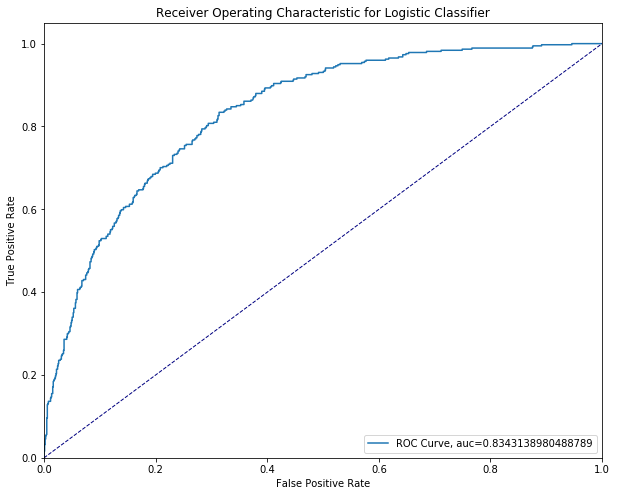

In [33]:
y_pred_lr = pipeline.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test,  y_pred_lr[:,1])
auc_LR = roc_auc_score(y_test, y_pred_lr[:,1])

print("Area Under Curve Score : " + str(auc_LR))

#PLOT ROC
lw = 1
plt.figure(figsize=(10,8))
plt.plot(fpr, tpr, label= 'ROC Curve, auc='+str(auc_LR))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.legend(loc=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Logistic Classifier')
plt.show()

## 2. Gradient boosted trees model :

Function for nested cross-validation, useful for tuning the hyper parameters n_estimators.

In [40]:
def nested_cv(X, y, est_pipe, p_grid, p_score, n_splits_inner = 3, n_splits_outer = 3, n_cores = 1, seed = 0):
    ests = []
    # cross-validation schema for inner and outer loops
    inner_cv = StratifiedKFold(n_splits = n_splits_inner, shuffle = True, random_state = seed)
    outer_cv = StratifiedKFold(n_splits = n_splits_outer, shuffle = True, random_state = seed)

    # grid search to tune hyper parameters
    est = GridSearchCV(estimator = est_pipe, param_grid = p_grid, cv = inner_cv, scoring = p_score, n_jobs = n_cores)
    ests.append(est)
    # nested CV with parameter optimization
    nested_scores = cross_val_score(estimator = est, X = X, y = y, cv = outer_cv, scoring = p_score, n_jobs = n_cores)
    
    print('Average score: %0.4f (+/- %0.4f)' % (nested_scores.mean(), nested_scores.std() * 1.96))
    
    return nested_scores, ests

### Hyper-parameter tuning

In [41]:
seed=0

array = []
array.append(('XGB_clf', XGBClassifier()))
pipe = Pipeline(array)
pipe.set_params(XGB_clf__random_state = seed)

# Possible optimized values 
p_grid = {"XGB_clf__n_estimators": [int(i) for i in np.linspace(10.0, 40.0, 5)]}

nested_scores_xgb, ests_xgb = nested_cv(X = stand_feat, y = target, est_pipe = pipe, p_grid = p_grid, p_score = 'accuracy', n_cores = -1)
optimal_param = list(p_grid.values())[0][np.argmax(nested_scores_xgb)]
print('Optimal n_estimators value : '+str(optimal_param))

Average score: 0.7984 (+/- 0.0082)
Optimal n_estimators value : 25


### Performance of the tuned model on test set

In [ ]:
optimal_xgb =  XGBClassifier(n_estimators=optimal_param)
optimal_xgb.fit(X_train,y_train)
xgb_pred = optimal_xgb.predict(X_test)
score = accuracy_score(y_test, xgb_pred)

print("Optimal Gradient Boosted trees model score : " + str(score))

### Roc Curve 

In [ ]:
xgb_prob = optimal_xgb.predict_proba(X_test)[:, 1]

fpr_xgb, tpr_xgb, thresholds = roc_curve(y_test, xgb_prob)

auc_xgb = roc_auc_score(y_test, xgb_prob)

print("Gradient Boosted trees model AUC score : " + str(auc_xgb))

plt.figure(figsize=(10,8))
plt.plot(fpr_xgb, tpr_xgb, label= 'ROC Curve, auc='+str(auc_xgb))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.legend(loc=4)
plt.xlim([0.0, 1.01])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Gradient boosted trees model')
plt.show()

## 3. Random Forest:

### Hyper-parameter tuning

In [34]:
# Define a random classifier pipeline
estimators = []
estimators.append(('rf_clf', RandomForestClassifier()))
pipeline = Pipeline(estimators)
pipeline.set_params(rf_clf__random_state = seed)
    
# Finding best value of n_estimators using validation set
scores = []
NSs = []
for NS in [int(i) for i in np.linspace(10, 100, 10)]:
    pipeline.set_params(rf_clf__n_estimators = NS) 
    pipeline.fit(X_train_train,y_train_train)
    y_train_pred = pipeline.predict(X_train_val)
    scores.append(accuracy_score(y_train_val, y_train_pred))
    NSs.append(NS)

best_NS = NSs[scores.index(max(scores))]
print ('best NS = %d with auc score = %2.4f' %(best_NS, max(scores)))

best NS = 30 with auc score = 0.8038


### Performance of the tuned model on test set

In [35]:
# Performance of the tuned model on test set
pipeline.set_params(rf_clf__n_estimators = best_NS)
pipeline.fit(X_train,y_train)
y_pred_rf = pipeline.predict(X_test)
score = accuracy_score(y_test, y_pred_rf)
print ('Random Forest Classifier accuracy score = %2.4f' %score)

Random Forest Classifier accuracy score = 0.7854


### Roc Curve 

Area under curve score : 0.8087510547649492


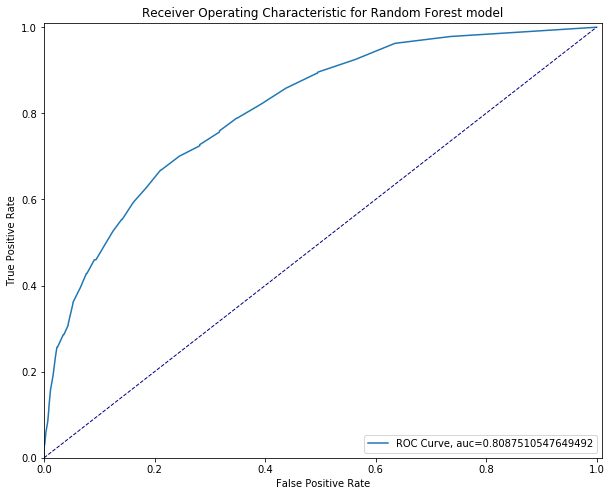

In [36]:
rf_prob = pipeline.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, thresholds = roc_curve(y_test, rf_prob)
auc_rf = roc_auc_score(y_test, rf_prob)

print("Area under curve score : " + str(auc_rf))

plt.figure(figsize=(10,8))
plt.plot(fpr_rf, tpr_rf, label= 'ROC Curve, auc='+str(auc_rf))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.legend(loc=4)
plt.xlim([0.0, 1.01])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Random Forest model')
plt.show()

## 4. KNN :

In [37]:
# creating odd list of K for KNN
numbers = list(range(1,30))

# subsetting just the odd ones
neighbors = list(filter(lambda x: x % 2 != 0, numbers))

# empty list that will hold cv scores
cv_scores = []

# perform 5-fold cross validation
for n in neighbors:
    knn = KNeighborsClassifier(n_neighbors=n)
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())


# determining best number of neighbors n
optimal_n = neighbors[np.argmax(cv_scores)]
print("The optimal number of neighbors is %d" % optimal_n)

The optimal number of neighbors is 25


### Performance of the tuned model on test set

In [38]:
knn = KNeighborsClassifier(n_neighbors=optimal_n)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

score = accuracy_score(y_test, y_pred)

print("KNN Accuracy score : " + str(score))

KNN Accuracy score : 0.7626154939587776


### Roc Curve 

The auc score for KNN : 0.8023046937687334


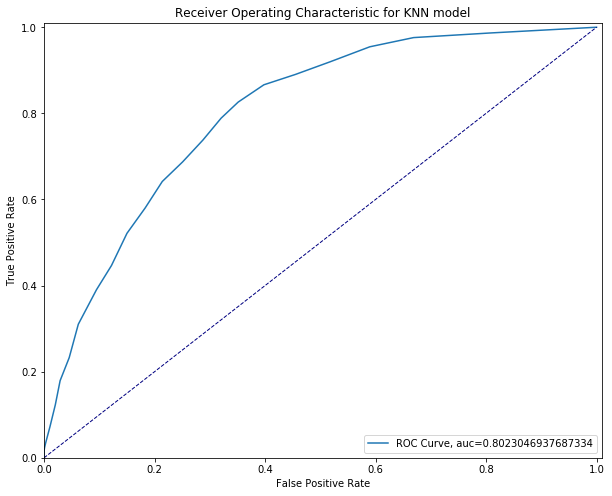

In [39]:
y_prob = knn.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_prob)
print("The auc score for KNN : " + str(auc))
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(10,8))
plt.plot(fpr, tpr, label= 'ROC Curve, auc='+str(auc))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.legend(loc=4)
plt.xlim([0.0, 1.01])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for KNN model')
plt.show()

## Best model : 

**We can see that from the proposed models the best one is the Gradient Boosted trees with an accuracy of 0.8098, hence we can predict almost 81% of costumer loyalty correctly.**